In [1]:
import time
from pynput import keyboard
import sys
import os
import mujoco.viewer

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from utils.Keyboard import uav_key_handler
import matplotlib.pyplot as plt
import casadi as cd
from Envs.UAV import UAV_env_mj, UAV_model

from Solvers.OCsolver import  ocsolver_v3
from Solvers.Cutter import  cutter_v3
from Solvers.MVEsolver import mvesolver
import numpy as np

from utils.RBF import generate_phi_rbf, gen_eval_rbf

from utils.Visualize_mj import uav_visualizer_mj_v4
from poly_feature import gen_poly_feats,gen_poly_feats_single_v,gen_poly_feats_v_full
from scipy.spatial.transform import Rotation as R
Horizon = 15  # 25
uav_params = {'gravity': 9.8, 'm': 0.1, 'J_B': 0.01 * np.eye(3), 'l_w': 1.2, 'dt': 0.1, 'c': 1}
filepath = os.path.join(os.path.abspath(os.path.dirname(os.getcwd())),
                        'mujoco_uav', 'bitcraze_crazyflie_2',
                        'scene_revise_geom.xml')
print('path', filepath)
uav_env = UAV_env_mj(filepath, lock_flag=True)
uav_model = UAV_model(**uav_params)
dyn_f = uav_model.get_dyn_f()
######################################################################################

# r,v,q,w,u
step_cost_vec = np.array([5.0, 400, 1, 5, 1]) * 1e-2
step_cost_f = uav_model.get_step_cost_param(step_cost_vec)
term_cost_vec = np.array([10, 6, 1, 5]) * 1e0
term_cost_f = uav_model.get_terminal_cost_param(term_cost_vec)
#####################################################################################
#additional cost
phi_func_poly = gen_poly_feats(Horizon=Horizon, con_idx=4, bias = -1)
constraint_weights = np.load("../Data/uav_revise/theta_poly_3.npy")

def generate_add_func(weights,Horizon=Horizon):
    x_dim = 13
    u_dim = 4
    traj = cd.SX.sym('xi', (x_dim + u_dim) * Horizon + x_dim)
    phi = phi_func_poly(traj)
    feature_weights = cd.vertcat(1, weights)
    g = cd.dot(phi, feature_weights)
    ln_g =  - 60 * cd.log(-g)
    add_func = cd.Function('mtimes', [traj], [ln_g])   
    return add_func

add_func = generate_add_func(constraint_weights, Horizon=Horizon)
#########################################################################################
#constraint vector
phi_func = gen_poly_feats_v_full(Horizon=Horizon, bias=-1, start_idx=1, end_idx=10)
phi_func_single = gen_poly_feats_single_v(bias=-1)

#########################################################################################
controller = ocsolver_v3('uav control')
controller.set_state_param(13, None, None)
controller.set_ctrl_param(4, [-1e10, -1e10, -1e10, -1e10], [1e10, 1e10, 1e10, 1e10])
controller.set_dyn(dyn_f)
controller.set_step_cost(step_cost_f)
controller.set_term_cost(term_cost_f)
controller.set_additional_cost(add_func)
controller.set_g(phi_func, gamma=100.0)
controller.construct_prob(horizon=Horizon)
# init_theta = learned_theta = (hypo_lbs + hypo_ubs) / 2
######################################################################################

hypo_lbs = -0.0 * np.ones(8)
hypo_ubs = 0.6 * np.ones(8)

hb_calculator = cutter_v3('uav cut')
hb_calculator.from_controller(controller)
hb_calculator.construct_graph(horizon=Horizon)

mve_calc = mvesolver('uav_mve', 8)
mve_calc.set_init_constraint(hypo_lbs, hypo_ubs)  # Theta_0


init_r = np.array([0.0,0.0,5.0]).reshape(-1, 1)
init_v = np.zeros((3, 1))
init_q = np.reshape(np.array([1, 0, 0, 0]), (-1, 1))
# print(Quat_Rot(init_q))
init_w_B = np.zeros((3, 1))
init_x = np.concatenate([init_r, init_v, init_q, init_w_B], axis=0)

target_r = np.array([15.0,0.0,10.0])
target_x = np.concatenate([target_r.reshape(-1,1), init_v, init_q, init_w_B], axis=0)

def eval_weights(weights, horizon=Horizon):
    """
    Evaluate the weights using the MVE solver.
    """
    uav_env.set_init_state(init_x)
    controller.reset_warmstart()
    traj = [uav_env.get_curr_state()]
    for i in range(100):
        x = uav_env.get_curr_state()
        
        print("current constraint vec", phi_func_single(x))
   
        uav_v = x[3:6].flatten()
        print("uav_v", uav_v, np.linalg.norm(uav_v))

        u = controller.control(x, weights= weights, target_r=target_r)
        print("predicted vel",controller.opt_traj[2* 17 + 3:2*17+6])
        # controller.warm_start_sol[7:10] = 0
        print(u)

        uav_env.step(u)
        traj.append(uav_env.get_curr_state())
    
    return np.array(traj)

def eval_weights_long(weights, horizon=Horizon):
    """
    Evaluate the weights using the MVE solver.
    """
    viewer = mujoco.viewer.launch_passive(uav_env.model,uav_env.data)
    uav_env.set_init_state(init_x)
    controller.reset_warmstart()
    traj = [uav_env.get_curr_state()]
    for i in range(10000):
        x = uav_env.get_curr_state()
        
        print("current constraint vec", phi_func_single(x))
   
        uav_v = x[3:6].flatten()
        print("uav_v", uav_v, np.linalg.norm(uav_v))

        u = controller.control(x, weights= weights, target_r=target_r)
        print("predicted vel",controller.opt_traj[2* 17 + 3:2*17+6])
        # controller.warm_start_sol[7:10] = 0
        print(u)

        uav_env.step(u)
        traj.append(uav_env.get_curr_state())
        viewer.sync()
    

path /home/zxxie/ASU_research/safe_alignment/code/Safety-Alignment-with-Human-Directional-Feedback/mujoco_uav/bitcraze_crazyflie_2/scene_revise_geom.xml


In [2]:
weights = np.load("../Data/uav_revise/weights_vel_long/weights_init.npy")
traj = eval_weights(weights, horizon=Horizon)
traj_list = [np.linalg.norm(traj[:,3:6],axis=1)]

for i in range(1,18):
    weights = np.load("../Data/uav_revise/weights_vel_long/weights_{}.npy".format(i))
    traj = eval_weights(weights, horizon=Horizon)
    traj_list.append(np.linalg.norm(traj[:,3:6],axis=1))


current constraint vec [-1, 0, 0, 0]
uav_v [0. 0. 0.] 0.0
predicted vel [-5.01700989e-35 -8.90216566e-35  2.02974373e-01]
[-0.09111166  0.36640779  0.71052061  0.25166001]
current constraint vec [-1, 4.36873e-09, 8.95834e-11, 0.000657379]
uav_v [6.60963460e-05 9.46484918e-06 2.56394111e-02] 0.025639497999733085
predicted vel [0.03490676 0.00500366 0.23178469]
[-0.04145641  0.34461414  0.63568651  0.24843339]
current constraint vec [-1, 2.49534e-07, 5.11698e-09, 0.00213601]
uav_v [4.99534178e-04 7.15330997e-05 4.62170333e-02] 0.04621978817822207
predicted vel [0.0740444  0.0106114  0.25686429]
[0.00916756 0.32662498 0.56671157 0.24823142]
current constraint vec [-1, 2.51811e-06, 5.16344e-08, 0.00397829]
uav_v [0.00158686 0.00022723 0.06307371] 0.06309407965052462
predicted vel [0.1151793  0.01652003 0.2777535 ]
[0.05913457 0.31200458 0.50410125 0.25036566]
current constraint vec [-1, 1.25831e-05, 2.58135e-07, 0.00598048]
uav_v [0.00354727 0.00050807 0.07733359] 0.0774165729749693
predic

CasADi - 2025-05-30 09:40:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.142712, 0.00332888, 0.0588425]
uav_v [0.37777221 0.05769647 0.24257481] 0.4526403201372455
predicted vel [0.65899174 0.09624931 0.23646618]
[0.28917338 0.24752526 0.21655012 0.25838354]
current constraint vec [-1, 0.15161, 0.00357654, 0.0583993]
uav_v [0.38937101 0.05980417 0.24165938] 0.4621532027077662
predicted vel [0.65895882 0.09649563 0.23611922]
[0.28130346 0.24803423 0.22341566 0.25685483]
current constraint vec [-1, 0.160137, 0.00382252, 0.05792]
uav_v [0.40017134 0.06182653 0.24066583] 0.47104104253349444
predicted vel [0.65828921 0.09666508 0.23588915]
[0.2738647  0.24857892 0.23002034 0.25546078]
current constraint vec [-1, 0.168238, 0.00406548, 0.0574233]
uav_v [0.410168   0.06376113 0.23963152] 0.47929796201210356
predicted vel [0.65705456 0.09676596 0.23574725]
[0.26688846 0.2491444  0.23631254 0.25419619]
current constraint vec [-1, 0.175865, 0.00430417, 0.0569239]
uav_v [0.41936274 0.06560618 0.23858721] 0.4869221022279284
predicted vel [0

CasADi - 2025-05-30 09:40:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0881459, 0.00198332, 0.0605777]
uav_v [0.29689374 0.04453447 0.24612529] 0.3882098289049068
predicted vel [0.64923441 0.09466929 0.24547398]
[0.34306257 0.24603573 0.17348827 0.27081066]
current constraint vec [-1, 0.0978837, 0.0022197, 0.0609018]
uav_v [0.31286371 0.04711373 0.24678285] 0.40125450968864285
predicted vel [0.65448533 0.09556388 0.24357884]
[0.33384838 0.24603018 0.18036157 0.26846215]
current constraint vec [-1, 0.10773, 0.0024637, 0.0610137]
uav_v [0.32822298 0.04963566 0.24700942] 0.4137724878361815
predicted vel [0.65864263 0.09632443 0.24206358]
[0.32456432 0.24615164 0.187539   0.26621955]
current constraint vec [-1, 0.11759, 0.00271367, 0.0609477]
uav_v [0.3429143  0.05209289 0.24687589] 0.42573652691729025
predicted vel [0.66178258 0.09696059 0.24087653]
[0.3153488  0.24638694 0.1948856  0.2640998 ]
current constraint vec [-1, 0.127371, 0.00296797, 0.0607377]
uav_v [0.3568904  0.05447907 0.24645022] 0.4371229050225277
predicted vel [

CasADi - 2025-05-30 09:40:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0380554, 0.000809417, 0.0538521]
uav_v [0.19507788 0.02845026 0.23206054] 0.3044944846289426
predicted vel [0.59884464 0.08615944 0.27038099]
[0.38816727 0.24962009 0.14685585 0.28572203]
current constraint vec [-1, 0.0454405, 0.00097089, 0.056044]
uav_v [0.21316767 0.0311591  0.23673604] 0.320086393730265
predicted vel [0.61216014 0.08805696 0.26525635]
[0.38331498 0.24868498 0.1485107  0.28346375]
current constraint vec [-1, 0.0534554, 0.00114787, 0.0578929]
uav_v [0.2312042  0.03388017 0.24060954] 0.3354045261558063
predicted vel [0.62406293 0.08976965 0.26069109]
[0.37723907 0.24789682 0.15139513 0.28106062]
current constraint vec [-1, 0.0620347, 0.00133945, 0.0593984]
uav_v [0.24906776 0.03659856 0.24371787] 0.350389218708934
predicted vel [0.63457536 0.09130475 0.25669537]
[0.37013845 0.2472612  0.15537605 0.27857335]
current constraint vec [-1, 0.0711014, 0.00154455, 0.0605708]
uav_v [0.26664839 0.03930072 0.24611141] 0.3649886833224256
predicted ve

CasADi - 2025-05-30 09:40:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0118439, 0.000247932, 0.039313]
uav_v [0.10882954 0.01574584 0.19827503] 0.2267262406765323
predicted vel [0.51189402 0.07395622 0.30695157]
[0.38679495 0.25652906 0.16214738 0.29262114]
current constraint vec [-1, 0.015667, 0.00032896, 0.0428311]
uav_v [0.12516779 0.01813727 0.20695679] 0.2425428837173113
predicted vel [0.53258764 0.07690133 0.30009971]
[0.39147444 0.25498215 0.15549849 0.29223117]
current constraint vec [-1, 0.0202087, 0.000425709, 0.0462012]
uav_v [0.14215725 0.02063273 0.21494469] 0.2585258437846431
predicted vel [0.55175459 0.07962189 0.29334146]
[0.39374866 0.25354979 0.15084017 0.29130499]
current constraint vec [-1, 0.025488, 0.000538821, 0.0493608]
uav_v [0.15964952 0.02321251 0.22217281] 0.2745679232299328
predicted vel [0.56942751 0.08212712 0.28683161]
[0.39387853 0.25223169 0.14799395 0.28992608]
current constraint vec [-1, 0.0315053, 0.000668597, 0.0522569]
uav_v [0.17749737 0.02585724 0.22859764] 0.2905697813766416
predicted

CasADi - 2025-05-30 09:40:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.000519444, 1.08763e-05, 0.016417]
uav_v [0.02279132 0.00329793 0.12812877] 0.1301818024873363
predicted vel [0.30619705 0.04457918 0.34027198]
[0.26616184 0.27363015 0.28334605 0.27564558]
current constraint vec [-1, 0.00095092, 1.99521e-05, 0.0193014]
uav_v [0.03083699 0.00446678 0.13892949] 0.1423807422939704
predicted vel [0.33848139 0.04932387 0.34091456]
[0.29442003 0.2698287  0.25568048 0.28013402]
current constraint vec [-1, 0.00161652, 3.39922e-05, 0.0223888]
uav_v [0.04020599 0.00583028 0.1496289 ] 0.15504619381221763
predicted vel [0.36861787 0.05374582 0.33948588]
[0.31846944 0.26672763 0.23228545 0.28397171]
current constraint vec [-1, 0.0025866, 5.45153e-05, 0.0256683]
uav_v [0.05085866 0.00738344 0.16021339] 0.16825412099772447
predicted vel [0.39672383 0.05785846 0.33640908]
[0.33851871 0.26414145 0.21268158 0.28707426]
current constraint vec [-1, 0.00393481, 8.31265e-05, 0.0291109]
uav_v [0.0627281  0.00911738 0.1706191 ] 0.1820132396730615

CasADi - 2025-05-30 09:40:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 2.41216e-07, 5.06026e-09, 0.00238061]
uav_v [4.91137740e-04 7.11355291e-05 4.87914449e-02] 0.04879396858395675
predicted vel [0.07181366 0.0104103  0.26483496]
[0.02006825 0.32841956 0.56080531 0.25143395]
current constraint vec [-1, 2.42808e-06, 5.09398e-08, 0.00444018]
uav_v [0.00155823 0.0002257  0.06663471] 0.06665330420929926
predicted vel [0.11176968 0.0162173  0.2861282 ]
[0.06876767 0.31348433 0.498714   0.25313279]
current constraint vec [-1, 1.21041e-05, 2.54078e-07, 0.00667872]
uav_v [0.00347909 0.00050406 0.08172346] 0.08179903908695259
predicted vel [0.15200394 0.02208764 0.30322212]
[0.11563963 0.30149325 0.44313002 0.25656101]
current constraint vec [-1, 4.11783e-05, 8.65261e-07, 0.00902054]
uav_v [0.00641703 0.00093019 0.09497652] 0.09519759656960505
predicted vel [0.19135007 0.02785198 0.31626042]
[0.15961585 0.29195551 0.39398527 0.26107005]
current constraint vec [-1, 0.000110157, 2.31791e-06, 0.0114667]
uav_v [0.01049557 0.00152247 0.1070

CasADi - 2025-05-30 09:40:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0913417, 0.00212387, 0.0694619]
uav_v [0.30222791 0.04608551 0.26355623] 0.403642749889951
predicted vel [0.5943498  0.08790559 0.23175031]
[0.31948981 0.24823298 0.19521026 0.26668118]
current constraint vec [-1, 0.0996899, 0.0023373, 0.0696649]
uav_v [0.31573709 0.04834564 0.263941  ] 0.4143574110227962
predicted vel [0.59714553 0.08846438 0.23055823]
[0.31078731 0.24839188 0.20200088 0.26459801]
current constraint vec [-1, 0.107971, 0.00255401, 0.0696968]
uav_v [0.32858996 0.05053725 0.2640015 ] 0.42452581495062214
predicted vel [0.59909116 0.08891662 0.22959602]
[0.30227131 0.24863591 0.20881324 0.26263733]
current constraint vec [-1, 0.116112, 0.00277258, 0.0695879]
uav_v [0.34075183 0.05265531 0.26379528] 0.4341340126278119
predicted vel [0.60025719 0.08927146 0.22882611]
[0.29402548 0.24895102 0.21555641 0.26080614]
current constraint vec [-1, 0.124042, 0.00299161, 0.0693665]
uav_v [0.35219641 0.05469559 0.26337525] 0.44317089853214336
predicted vel

CasADi - 2025-05-30 09:40:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0640209, 0.00146664, 0.0642526]
uav_v [0.25302353 0.0382967  0.25348102] 0.3601946325129719
predicted vel [0.56868482 0.08408948 0.23896966]
[0.3430144  0.24811873 0.17759993 0.27273013]
current constraint vec [-1, 0.0717636, 0.00165476, 0.0651385]
uav_v [0.26788729 0.0406787  0.25522249] 0.37223228622170546
predicted vel [0.57417125 0.08498251 0.23684919]
[0.334568   0.24799478 0.18362946 0.27042833]
current constraint vec [-1, 0.0796734, 0.00185017, 0.0657785]
uav_v [0.28226478 0.04301366 0.2564731 ] 0.38379947135900583
predicted vel [0.57863242 0.08574508 0.2350613 ]
[0.32595095 0.24798439 0.19001433 0.26819635]
current constraint vec [-1, 0.0876725, 0.00205152, 0.0661999]
uav_v [0.29609547 0.04529374 0.25729338] 0.39487204834750506
predicted vel [0.58213686 0.08638632 0.23356778]
[0.31730751 0.248077   0.19662104 0.26605579]
current constraint vec [-1, 0.0956838, 0.00225741, 0.0664316]
uav_v [0.30932798 0.04751216 0.25774326] 0.40542914489555637
predic

CasADi - 2025-05-30 09:40:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0394341, 0.000901097, 0.0553036]
uav_v [0.19858011 0.03001828 0.23516713] 0.3092551287245605
predicted vel [0.52382138 0.07791039 0.23194606]
[0.36080862 0.24828835 0.16523082 0.27798767]
current constraint vec [-1, 0.0457318, 0.00105014, 0.0568847]
uav_v [0.21384989 0.03240585 0.23850524] 0.3219730772759186
predicted vel [0.53239767 0.07920174 0.22897253]
[0.3540951  0.24782692 0.16924133 0.27574296]
current constraint vec [-1, 0.0523879, 0.00120945, 0.0581885]
uav_v [0.22888394 0.03477719 0.24122288] 0.33434382389891537
predicted vel [0.53981481 0.08034037 0.22639085]
[0.34670812 0.24749789 0.17403104 0.2734695 ]
current constraint vec [-1, 0.0593399, 0.001378, 0.0592279]
uav_v [0.24359791 0.0371214  0.24336785] 0.34633199404102777
predicted vel [0.54611942 0.08133456 0.22418009]
[0.33882266 0.24729599 0.17945828 0.27120617]
current constraint vec [-1, 0.0665207, 0.00155462, 0.0600217]
uav_v [0.25791601 0.03942871 0.24499336] 0.35790646512654267
predicte

CasADi - 2025-05-30 09:40:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0224899, 0.000510104, 0.0425774]
uav_v [0.14996617 0.02258549 0.20634291] 0.25608075709717903
predicted vel [0.48683939 0.0726342  0.23715651]
[0.3719948  0.24867794 0.1584021  0.28194346]
current constraint vec [-1, 0.0272639, 0.000620767, 0.0446279]
uav_v [0.16511786 0.0249152  0.21125316] 0.26928158554133275
predicted vel [0.49884631 0.0744023  0.23315769]
[0.36835805 0.24787477 0.15942195 0.28013476]
current constraint vec [-1, 0.0325216, 0.00074359, 0.0464395]
uav_v [0.18033745 0.02726885 0.21549823] 0.2823201626508496
predicted vel [0.50962053 0.075997   0.22953352]
[0.36354287 0.24721047 0.16159038 0.27815425]
current constraint vec [-1, 0.0382279, 0.000878077, 0.0480033]
uav_v [0.19551949 0.02963237 0.21909661] 0.2951428048577043
predicted vel [0.51918694 0.07742544 0.22630002]
[0.35773598 0.24668431 0.16477454 0.27605693]
current constraint vec [-1, 0.0443378, 0.00102354, 0.0493188]
uav_v [0.21056551 0.03199275 0.22207839] 0.30770144809389527
pred

CasADi - 2025-05-30 09:40:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0029338, 6.5839e-05, 0.0231098]
uav_v [0.05416453 0.00811413 0.15201913] 0.16158419120004386
predicted vel [0.35686544 0.05364929 0.26527329]
[0.34489984 0.25792148 0.19649482 0.28353893]
current constraint vec [-1, 0.00426231, 9.58873e-05, 0.0258078]
uav_v [0.06528635 0.0097922  0.16064819] 0.17368372017408346
predicted vel [0.3775902  0.05675646 0.26109251]
[0.35534946 0.25596834 0.18517989 0.28466445]
current constraint vec [-1, 0.0059688, 0.000134618, 0.0285232]
uav_v [0.07725799 0.01160251 0.16888819] 0.18608233955439754
predicted vel [0.39689446 0.0596389  0.25656081]
[0.36303722 0.25425611 0.17627887 0.2851947 ]
current constraint vec [-1, 0.00809557, 0.000183069, 0.0312119]
uav_v [0.0899754  0.01353031 0.17666879] 0.19872217550022422
predicted vel [0.4148291  0.0623062  0.25186179]
[0.36822964 0.25274404 0.16953583 0.28518165]
current constraint vec [-1, 0.0106765, 0.000242109, 0.033829]
uav_v [0.10332722 0.01555987 0.18392659] 0.21153631488683544


CasADi - 2025-05-30 09:40:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 8.21157e-05, 1.83451e-06, 0.00810284]
uav_v [0.00906177 0.00135444 0.09001576] 0.09048086986841519
predicted vel [0.19398181 0.02914485 0.25550174]
[0.21066558 0.27860964 0.33138613 0.26312423]
current constraint vec [-1, 0.000186071, 4.16473e-06, 0.0099718]
uav_v [0.0136408  0.00204077 0.09985889] 0.10080691850569212
predicted vel [0.2238147  0.03368018 0.25875478]
[0.24213855 0.27299701 0.29854037 0.2674506 ]
current constraint vec [-1, 0.000373057, 8.3671e-06, 0.0119484]
uav_v [0.01931468 0.00289259 0.10930869] 0.11103969368785903
predicted vel [0.25194989 0.03796353 0.25997413]
[0.26960112 0.26841823 0.2704159  0.27144417]
current constraint vec [-1, 0.000680935, 1.53057e-05, 0.0140395]
uav_v [0.02609472 0.00391225 0.11848823] 0.12139069178004022
predicted vel [0.27838368 0.04198818 0.25952495]
[0.2931473  0.26465007 0.24654087 0.27495074]
current constraint vec [-1, 0.00115368, 2.59909e-05, 0.0162425]
uav_v [0.03396587 0.00509813 0.12744594] 0.131992951

CasADi - 2025-05-30 09:40:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


predicted vel [0.09384584 0.01408944 0.22394503]
[0.09762797 0.30368074 0.45764161 0.25098516]
current constraint vec [-1, 8.59817e-06, 1.93251e-07, 0.00450427]
uav_v [0.00293226 0.0004396  0.06711386] 0.0671793250277345
predicted vel [0.12657344 0.0190339  0.23486368]
[0.13934786 0.29332556 0.4090258  0.25455436]
current constraint vec [-1, 2.93349e-05, 6.60186e-07, 0.0061487]
uav_v [0.00541617 0.00081252 0.07841366] 0.07860468952227584
predicted vel [0.15845309 0.02387075 0.24283594]
[0.17778001 0.28490089 0.36620751 0.25869435]
current constraint vec [-1, 7.85407e-05, 1.77045e-06, 0.00787765]
uav_v [0.00886232 0.00133058 0.08875615] 0.08920742369815998
predicted vel [0.18902522 0.02852634 0.24816038]
[0.21248663 0.2780601  0.32889151 0.26301789]
current constraint vec [-1, 0.000177924, 4.01824e-06, 0.0096983]
uav_v [0.01333882 0.00200456 0.09847994] 0.09939940307878856
predicted vel [0.21804856 0.03295788 0.25118619]
[0.24326235 0.27249645 0.29667678 0.26722507]
current constraint v

CasADi - 2025-05-30 09:40:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0816666, 0.00206179, 0.0388633]
uav_v [0.28577366 0.04540688 0.19713783] 0.35013096830336726
predicted vel [0.50133721 0.07686852 0.18682897]
[0.28155342 0.24585582 0.21970566 0.2555303 ]
current constraint vec [-1, 0.087347, 0.00222488, 0.0387461]
uav_v [0.29554518 0.04716859 0.19684029] 0.35821491525055893
predicted vel [0.50158906 0.07705638 0.18646584]
[0.27500893 0.24633751 0.22540276 0.25419108]
current constraint vec [-1, 0.0928573, 0.00238733, 0.0385882]
uav_v [0.304725   0.04886035 0.19643884] 0.3658317632058576
predicted vel [0.50135686 0.07718112 0.18618082]
[0.26881981 0.24683668 0.23086995 0.25295986]
current constraint vec [-1, 0.0981589, 0.00254821, 0.0384009]
uav_v [0.31330316 0.05047975 0.19596143] 0.37297178772529643
predicted vel [0.50069633 0.07725005 0.18595685]
[0.26301442 0.24734234 0.23606604 0.25183491]
current constraint vec [-1, 0.103218, 0.0027066, 0.0381936]
uav_v [0.32127532 0.05202499 0.19543191] 0.37962884693565313
predicted

CasADi - 2025-05-30 09:40:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0609904, 0.00151444, 0.0356659]
uav_v [0.2469624  0.03891577 0.18885417] 0.3133221436025427
predicted vel [0.4849483  0.07429012 0.18479536]
[0.30088803 0.24433261 0.20278222 0.25948725]
current constraint vec [-1, 0.0666266, 0.0016667, 0.035747]
uav_v [0.25812133 0.04082526 0.18906866] 0.3225527617839435
predicted vel [0.48690665 0.07469701 0.18409548]
[0.29373269 0.24470971 0.20872339 0.25788683]
current constraint vec [-1, 0.0722385, 0.00182136, 0.035753]
uav_v [0.26877223 0.04267743 0.18908472] 0.3313803026971422
predicted vel [0.48822724 0.07501939 0.18353277]
[0.28678125 0.24513678 0.21460852 0.25638397]
current constraint vec [-1, 0.0777777, 0.00197739, 0.0356982]
uav_v [0.2788865  0.04446784 0.18893956] 0.3397840868955053
predicted vel [0.4889695  0.07526543 0.18308361]
[0.28009527 0.2456014  0.22036832 0.25498349]
current constraint vec [-1, 0.0831989, 0.00213377, 0.0355952]
uav_v [0.28844216 0.04619278 0.18866702] 0.34774688527579434
predicted ve

CasADi - 2025-05-30 09:40:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0422011, 0.00103576, 0.0340412]
uav_v [0.20542896 0.03218319 0.18450252] 0.2779892001344929
predicted vel [0.46126003 0.0707343  0.18478467]
[0.32063918 0.2437113  0.18726531 0.26435859]
current constraint vec [-1, 0.0473268, 0.00116842, 0.034444]
uav_v [0.2175473  0.0341822  0.18559106] 0.28799183207426143
predicted vel [0.46533494 0.07141986 0.18355975]
[0.31354027 0.24387337 0.19273997 0.26256534]
current constraint vec [-1, 0.0525769, 0.00130629, 0.0347314]
uav_v [0.2292966  0.03614263 0.18636371] 0.29768213807124405
predicted vel [0.46861451 0.07199795 0.18254001]
[0.30637227 0.24411852 0.19842811 0.26083262]
current constraint vec [-1, 0.057902, 0.00144839, 0.0349174]
uav_v [0.24062843 0.03805772 0.1868619 ] 0.30703061533231046
predicted vel [0.47115972 0.07247719 0.1816991 ]
[0.29924426 0.2444347  0.20422382 0.25917579]
current constraint vec [-1, 0.063253, 0.00159373, 0.0350161]
uav_v [0.25150141 0.03992156 0.18712594] 0.31601077324608584
predicted

CasADi - 2025-05-30 09:40:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.0222856, 0.000541964, 0.027249]
uav_v [0.14928367 0.02328011 0.1650727 ] 0.2237779549967395
predicted vel [0.42150831 0.06489927 0.18046595]
[0.34166036 0.24323923 0.17149685 0.27008981]
current constraint vec [-1, 0.0261861, 0.000639521, 0.0280753]
uav_v [0.16182109 0.02528874 0.16755694] 0.23430944020923414
predicted vel [0.42905327 0.06606357 0.17840747]
[0.33639711 0.24300722 0.17481451 0.26837477]
current constraint vec [-1, 0.0303665, 0.00074503, 0.0287662]
uav_v [0.17426    0.02729525 0.16960599] 0.24469934322075154
predicted vel [0.4356194  0.06708999 0.17662074]
[0.33051253 0.2428987  0.17883469 0.26661578]
current constraint vec [-1, 0.0347925, 0.000857876, 0.0293272]
uav_v [0.18652737 0.02928953 0.17125172] 0.2549068170110932
predicted vel [0.44124677 0.06798652 0.17509268]
[0.32414816 0.2429042  0.18343877 0.26484548]
current constraint vec [-1, 0.0394246, 0.000977337, 0.0297666]
uav_v [0.19855641 0.03126238 0.1725299 ] 0.2648934724955872
predi

CasADi - 2025-05-30 09:40:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2025-05-30 09:40:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


current constraint vec [-1, 0.00719121, 0.000173866, 0.0186448]
uav_v [0.08480097 0.01318582 0.13654596] 0.16127576027735852
predicted vel [0.35460059 0.05499321 0.18244157]
[0.34900489 0.24557537 0.17122223 0.27478993]
current constraint vec [-1, 0.00923741, 0.000223985, 0.0198976]
uav_v [0.09611145 0.01496611 0.1410587 ] 0.17134454245774233
predicted vel [0.36700231 0.05689245 0.17940355]
[0.34921928 0.24463954 0.16923784 0.27396592]
current constraint vec [-1, 0.0116101, 0.000282385, 0.0210575]
uav_v [0.10775016 0.01680431 0.14511207] 0.1815213346794003
predicted vel [0.37831656 0.05862276 0.17655521]
[0.34800781 0.24387604 0.16859636 0.27288369]
current constraint vec [-1, 0.0143105, 0.000349217, 0.0221119]
uav_v [0.11962642 0.01868735 0.14870075] 0.19175925653727127
predicted vel [0.38856732 0.06019059 0.17393313]
[0.3455611  0.2432725  0.16914532 0.27159408]
current constraint vec [-1, 0.0173322, 0.000424466, 0.0230519]
uav_v [0.13165192 0.02060257 0.15182852] 0.2020113661593734


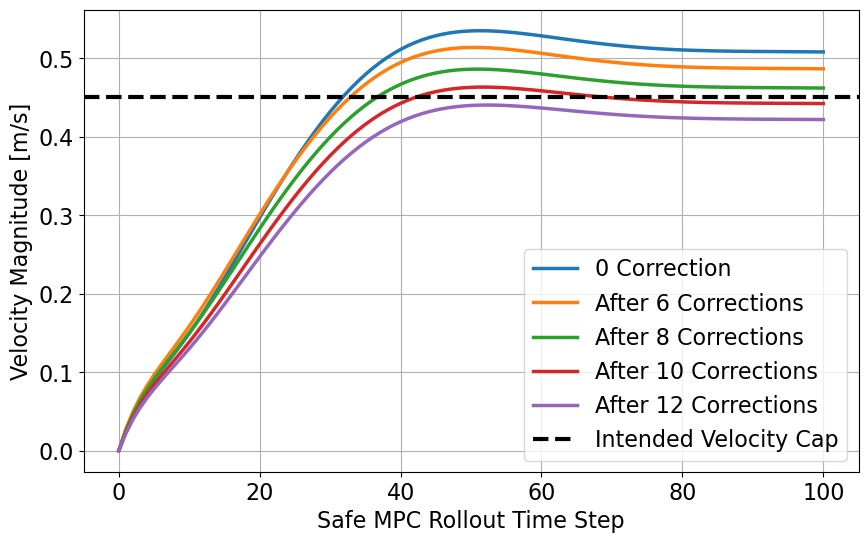

In [21]:
# Visualize the trajectories
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(traj_list[0], label='0 Correction', linewidth=2.5)
for i in [6,8,10,12]:
    plt.plot(traj_list[i], label=f'After {i} Corrections', linewidth=2.5)
# plt.title('Velocity Norms for Different Weights')
plt.xlabel('Safe MPC Rollout Time Step',fontsize=16)
plt.ylabel('Velocity Magnitude [m/s]',fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#horizontal line at 0.5
# plt.axhline(y=0.4, color='black', linestyle='dotted',linewidth=3, label='Correction Threshold (0.4)')
plt.axhline(y=0.45, color='black', linestyle='dashed',linewidth=3, label='Intended Velocity Cap')

plt.legend(fontsize=16)
plt.grid()
plt.show()

# eval_weights_long(weights, horizon=Horizon)